CSC 421 - Assignment 4 - Classifying handwritten digits using Numpy and Tensorflow.
Devroop Banerjee
V00837868
--
For this assignment, you should complete the exercises in this notebook. It is similar to the notebook posted for binary logistic regression. 

Look for requests containing the text **"your code"**. E.g. "put your code here", "replace None by your code", etc.
If there is no such request in a cell, just run the cell.

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import ndimage
import time
import pickle

%matplotlib inline

In [15]:
# Let's load the dataset of handwritten digits from a Python pickle file. 
# For information on pickle files, see: https://pythontips.com/2013/08/02/what-is-pickle-in-python
# The pickle file contains 55,000 training images and their labels as well as
# 10,000 test images and their labels.

fileObject = open('E:\study\CSC421\A4\mnist_nonbin_classification.pickle','rb')  
X,Y,X_test,Y_test = pickle.load(fileObject)
fileObject.close()


7
7


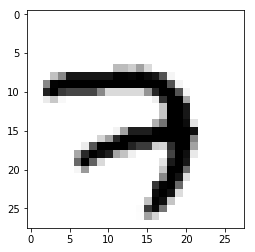

In [16]:
# Let's view some images

plt.figure()
plt.imshow(X[0,:].reshape((28,28)), cmap='Greys')

print(Y[0])
print(Y_test[0])

# Feel free to display other images by changing the index 0 above to some other index. 

In [17]:
# We will reshape the Y arrays so that they are not rank 1 arrays but rank 2 arrays. 
# They should be rank 2 arrays.

Y = Y.reshape((Y.shape[0],1))
Y_test = Y_test.reshape((Y_test.shape[0],1))

print("Train dataset shape", X.shape, Y.shape)
print("Test dataset shape", X_test.shape, Y_test.shape)

print("Y =", Y)

m   = X.shape[0] 
n_x = X.shape[1]

C = 10

Train dataset shape (55000, 784) (55000, 1)
Test dataset shape (10000, 784) (10000, 1)
Y = [[7]
 [3]
 [4]
 ..., 
 [5]
 [6]
 [8]]


Exercise 1 - One Hot Encoding
--

Convert Y to "one-hot" encoding. E.g. if the original Y is 
$$
Y = \begin{bmatrix}
    1 \\
    5 \\
    9  
\end{bmatrix}
$$
the new Y should be
$$
Y = \begin{bmatrix}
    0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
    0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0\\
    0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1\\ 
\end{bmatrix}
$$

In [18]:
# Toward this goal, let's check what np.arange(C) produces
np.arange(C)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [19]:
# Let's see again what Y is
Y

array([[7],
       [3],
       [4],
       ..., 
       [5],
       [6],
       [8]], dtype=uint8)

In [20]:
# What would broadcasting these arrays together would look like? 
# Let's check.

a,b = np.broadcast_arrays(np.arange(C), Y)

print("broadcasted np.arange(C) = \n", a)
print("broadcasted Y = \n", b)

broadcasted np.arange(C) = 
 [[0 1 2 ..., 7 8 9]
 [0 1 2 ..., 7 8 9]
 [0 1 2 ..., 7 8 9]
 ..., 
 [0 1 2 ..., 7 8 9]
 [0 1 2 ..., 7 8 9]
 [0 1 2 ..., 7 8 9]]
broadcasted Y = 
 [[7 7 7 ..., 7 7 7]
 [3 3 3 ..., 3 3 3]
 [4 4 4 ..., 4 4 4]
 ..., 
 [5 5 5 ..., 5 5 5]
 [6 6 6 ..., 6 6 6]
 [8 8 8 ..., 8 8 8]]


In [21]:
# If we compare np.arange(C) with Y using the equality sign ==, 
# the numpy broadcasting will do its magic to give us what we want. 
# Try it out. Then assign the result to a new variable Y_new. 
# Don't worry for the "True" and "False" values looking like strings. 
# They behave in fact like numbers, i.e. True is 1, False is 0.
# Finally, assign Y_new to Y so that we have to deal with Y in rest of the notebook.
# Cast the boolean values of Y_new to integer by calling Y_new.astype(int)

# Put your code in place of None objects 

Y_new = np.arange(C)==Y
print("Y_new=", Y_new)
Y=Y_new.astype(int)
print("Y=",Y)

Y_new_test = np.arange(C) ==Y_test
print("Y_new_test=", Y_new_test)
Y_test = Y_new_test.astype(int)
print("Y_test=",Y_test)

Y_new= [[False False False ...,  True False False]
 [False False False ..., False False False]
 [False False False ..., False False False]
 ..., 
 [False False False ..., False False False]
 [False False False ..., False False False]
 [False False False ..., False  True False]]
Y= [[0 0 0 ..., 1 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 1 0]]
Y_new_test= [[False False False ...,  True False False]
 [False False  True ..., False False False]
 [False  True False ..., False False False]
 ..., 
 [False False False ..., False False False]
 [False False False ..., False False False]
 [False False False ..., False False False]]
Y_test= [[0 0 0 ..., 1 0 0]
 [0 0 1 ..., 0 0 0]
 [0 1 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


*Expected output*

<pre>
Y_new= [[False False False ...,  True False False]
 [False False False ..., False False False]
 [False False False ..., False False False]
 ..., 
 [False False False ..., False False False]
 [False False False ..., False False False]
 [False False False ..., False  True False]]
Y= [[0 0 0 ..., 1 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 1 0]]
Y_new_test= [[False False False ...,  True False False]
 [False False  True ..., False False False]
 [False  True False ..., False False False]
 ..., 
 [False False False ..., False False False]
 [False False False ..., False False False]
 [False False False ..., False False False]]
Y_test= [[0 0 0 ..., 1 0 0]
 [0 0 1 ..., 0 0 0]
 [0 1 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]
</pre>

Exercise 2 - The Softmax Function
--
(Adapted from Andrew Ng's exercise in Coursera, deeplearning.ai)

Implement a softmax function using numpy. Softmax is a normalizing function used when the algorithm needs to classify two or more classes. 

**Instructions**:
- for $x \in \mathbb{R}^{1\times n}$ 
$$\mbox{softmax}(x) = \mbox{softmax}\left(\begin{bmatrix}
    x_1  &&
    x_2 &&
    ...  &&
    x_n  
\end{bmatrix}\right) = \begin{bmatrix}
     \frac{e^{x_1}}{\sum_{j}e^{x_j}}  &&
    \frac{e^{x_2}}{\sum_{j}e^{x_j}}  &&
    ...  &&
    \frac{e^{x_n}}{\sum_{j}e^{x_j}} 
\end{bmatrix} $$ 

- for a matrix $x \in \mathbb{R}^{m \times n}$  
$$\mbox{softmax}(x) = \mbox{softmax}\begin{bmatrix}
    x_{11} & x_{12} & x_{13} & \dots  & x_{1n} \\
    x_{21} & x_{22} & x_{23} & \dots  & x_{2n} \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    x_{m1} & x_{m2} & x_{m3} & \dots  & x_{mn}
\end{bmatrix} = \begin{bmatrix}
    \frac{e^{x_{11}}}{\sum_{j}e^{x_{1j}}} & \frac{e^{x_{12}}}{\sum_{j}e^{x_{1j}}} & \frac{e^{x_{13}}}{\sum_{j}e^{x_{1j}}} & \dots  & \frac{e^{x_{1n}}}{\sum_{j}e^{x_{1j}}} \\
    \frac{e^{x_{21}}}{\sum_{j}e^{x_{2j}}} & \frac{e^{x_{22}}}{\sum_{j}e^{x_{2j}}} & \frac{e^{x_{23}}}{\sum_{j}e^{x_{2j}}} & \dots  & \frac{e^{x_{2n}}}{\sum_{j}e^{x_{2j}}} \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    \frac{e^{x_{m1}}}{\sum_{j}e^{x_{mj}}} & \frac{e^{x_{m2}}}{\sum_{j}e^{x_{mj}}} & \frac{e^{x_{m3}}}{\sum_{j}e^{x_{mj}}} & \dots  & \frac{e^{x_{mn}}}{\sum_{j}e^{x_{mj}}}
\end{bmatrix} = \begin{pmatrix}
    \mbox{softmax}\text{(first row of x)}  \\
    \mbox{softmax}\text{(second row of x)} \\
    ...  \\
    \mbox{softmax}\text{(last row of x)} \\
\end{pmatrix} $$

In [22]:
def softmax(x):
    # Create an array x_exp by applying np.exp() element-wise to x. 
    # Put your code here (one line)
    x_exp=np.exp(x)
    # Create an array x_sum that contains the sum of each row of x_exp. 
    # Use np.sum(..., axis = 1, keepdims = True).
    # Put your code here (one line)
    x_sum=np.sum(x_exp, axis=1, keepdims= True)
    #print(x_sum)
    # Compute softmax(x) by dividing x_exp by x_sum. It should automatically use numpy broadcasting.
    # Return this array.
    # Replace None with your code
    return x_exp/x_sum


# Let's test
x = np.array([
    [1, 2, 3, 1, 2],
    [9, 5, 1, 0 ,0]])
print("softmax(x) = " + str(softmax(x)))

softmax(x) = [[  6.74508059e-02   1.83350300e-01   4.98397788e-01   6.74508059e-02
    1.83350300e-01]
 [  9.81452586e-01   1.79759312e-02   3.29240664e-04   1.21120871e-04
    1.21120871e-04]]


*Expected output*

<pre>
softmax(x) = [[  6.74508059e-02   1.83350300e-01   4.98397788e-01   6.74508059e-02
    1.83350300e-01]
 [  9.81452586e-01   1.79759312e-02   3.29240664e-04   1.21120871e-04
    1.21120871e-04]]
</pre>

Exercise 3 - Compute one semi-vectorized iteration for softmax
--
Perform one semi-vectorized iteration of gradient descent for the softmax classification.

In [23]:
# First do this for only one training example (the first one, i=0).
# Print out everything you compute, e.g. print("z", z), print("a", a), etc. 

J = 0
w = np.zeros((n_x,C))
b = np.zeros((1,C))

dw = np.zeros((n_x,C));
db = np.zeros((1,C));

i = 0;


# Replace None objects by your code

x = X[i:i+1, : ]  #x is [1,784]
y = Y[i:i+1, : ]
print("y", y)

z = x @ w + b
print("z", z)
a = softmax(z)
print("a", a)
J += np.sum(-y * np.log(a))
print("J", J)

dz = a-y
print("dz", dz)
dw += x.T * dz
print("dw", dw)
db += dz
print("db", db)

y [[0 0 0 0 0 0 0 1 0 0]]
z [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
a [[ 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1]]
J 2.30258509299
dz [[ 0.1  0.1  0.1  0.1  0.1  0.1  0.1 -0.9  0.1  0.1]]
dw [[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
db [[ 0.1  0.1  0.1  0.1  0.1  0.1  0.1 -0.9  0.1  0.1]]


*Expected output*

<pre>
y [[0 0 0 0 0 0 0 1 0 0]]
z [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
a [[ 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1]]
J 2.30258509299
dz [[ 0.1  0.1  0.1  0.1  0.1  0.1  0.1 -0.9  0.1  0.1]]
dw [[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
db [[ 0.1  0.1  0.1  0.1  0.1  0.1  0.1 -0.9  0.1  0.1]]
</pre>

In [24]:
#one iteration, semi-vectorized

J = 0
w = np.zeros((n_x,C))
b = np.zeros((1,C))

dw = np.zeros((n_x,C));
db = np.zeros((1,C));

alpha = 0.1

start_time = time.time()

for i in range(m):
    # Put your code here
    x = X[i:i+1, : ]  #x is [1,784]
    y = Y[i:i+1, : ]
    #print("y", y)

    z = x @ w + b
    #print("z", z)
    a = softmax(z)
   # print("a", a)
    J += np.sum(-y * np.log(a))
    #print("J", J)

    dz = a-y
   # print("dz", dz)
    dw += x.T * dz
    #print("dw", dw)
    db += dz
    #print("db", db)
    
    

J /= m; dw /= m; db /= m

w -= alpha*dw
b -= alpha*db

print("J", J)
print("Time needed: ", time.time() - start_time)

J 2.302585093
Time needed:  3.3213651180267334


*Expected output*

<pre>
J =  2.302585093
Time needed:  3.797287702560425
</pre>

Of course, your running time will be different.

Exercise 4 - Compute one fully-vectorized iteration for softmax
--
Perform one fully-vectorized iteration of gradient descent for the softmax classification.

In [12]:
#one iteration, fully vectorized, no for loop

J = 0
w = np.zeros((n_x,C))
b = np.zeros((1,C))

alpha = 0.1

start_time = time.time()


#Replace the None objects and alpha*0 by your code.

# Convention: 
# Use capital letter when the variable is for the whole dataset of m train examples.

# X is (55000,784), Y is (55000,10), w is (784,10), b is (1,10)  
Z = X @ w + b               # Z is  (55000, 10)
A = softmax(Z)              # A is  (55000, 10)
J = -(1/m)*np.sum(Y * np.log(A))

dZ = A - Y# dZ is (55000, 10)


dw = (1/m) * X.T @ dZ                #dw is (784, 10) 
db = (1/m) * np.sum(dZ,axis=0, keepdims=True)

w -= alpha*dw
b -= alpha*db

print("J = ", J)
print("Time needed: ", time.time() - start_time)

J =  2.30258509299
Time needed:  0.5166137218475342


*Expected output*

<pre>
J =  2.30258509299
Time needed:  0.5495262145996094
</pre>

We observe that the time of the fully vectorized version is almost one order of magnitude smaller. 

Exercise 5 - Compute several fully-vectorized iterations for softmax
--
Perform 100 fully-vectorized iterations of gradient descent for the softmax classification.
Start with doing 10 iterations first, check the accuracy you achieve, then try for 100 iterations. 
Print out the cost after each iteration.

In [13]:
J = 0
w = np.zeros((n_x,C))
b = np.zeros((1,C))

alpha = 0.1

#Replace the None objects and alpha*0 by your code.

# Convention: 
# Use capital letter when the variable is for the whole dataset of m train examples.

for iter in range(10):
    # X is (55000,784), Y is (55000,10), w is (784,10), b is (1,10)  
    Z = X @ w + b              # Z is  (55000, 10)
    A = softmax(Z)               # A is  (55000, 10)
    J = -(1/m) * np.sum(Y * np.log(A))
    print(iter, J)
    dZ = A - Y                 # dZ is (55000, 10)
    dw = (1/m) * X.T @ dZ              #dw is (784, 10) 
    db = (1/m) * np.sum(dZ,axis=0, keepdims=True)
    w -= alpha*dw
    b -= alpha*db

0 2.30258509299
1 2.19706377599
2 2.10085951391
3 2.0120441413
4 1.92974131203
5 1.85342090129
6 1.78266241239
7 1.71707943589
8 1.65629942394
9 1.59996131888


*Expected output*

<pre>
0 2.30258509299
1 2.19706377599
2 2.10085951391
3 2.0120441413
4 1.92974131203
5 1.85342090129
6 1.78266241239
7 1.71707943589
8 1.65629942394
9 1.59996131888
</pre>

Exercise 6 - Compute the accuracy
--
Compute the accuracy of softmax classification on the train and test datasets.

Use np.argmax(A, 1) and np.argmax(Y, 1) to find the predicted and real class for each example. They return an array of numbers each, e.g. [7 3 9 ..., 8 0 8] and [7 3 4 ..., 5 6 8]. Compare them using ==. You will get an array of booleans, e.g. [ True  True False ..., False False  True]. Sum up the latter using np.sum(). True values will be considered 1, False values will be considered 0, so the sum will tell us how many True values we got. Then divide by Y.shape[0] and multiply by 100 to get the accuracy in percentage.    

In [26]:
# Replace None by your code

def accuracy(A, Y):
    return 100*np.sum(np.argmax(A,1) == np.argmax(Y,1)) / Y.shape[0]

Z = X @ w + b
A = softmax(Z)

Z_test = X_test @ w + b
A_test = softmax(Z_test)

print("Accuracy on the train set is ", accuracy(A,Y))
print("Accuracy on the test set is ", accuracy(A_test,Y_test))

Accuracy on the train set is  66.2927272727
Accuracy on the test set is  67.05


*Expected output*

<pre>
Accuracy on the train set is  66.2927272727
Accuracy on the test set is  67.05
</pre>

Remark. These numbers are for 10 iterations. When you perform 100 iterations, the numbers will be much better.

Exercise 7 - Implement the Softmax classifier on TensorFlow
--
Implementing the Softmax classifier on TensorFlow is very similar to the TensorFlow example for binary logistic regression.

In [27]:
import tensorflow as tf

In [28]:
# Replace the None objects with your code.

# Input data.
# Load the training and test data into constants
tf_X = tf.constant(X)
tf_Y = tf.constant(Y)
tf_X_test = tf.constant(X_test)
tf_Y_test = tf.constant(Y_test)


# Variables.
# These are the parameters that we are going to be training.
tf_w = tf.Variable(tf.zeros((n_x,C)))
tf_b = tf.Variable(tf.zeros((1,C)))

# Training computation.
# We multiply the inuts with the weight matrix, and add biases. 
tf_Z = tf.matmul(tf_X, tf_w) + tf_b

# We compute
# the softmax and cross-entropy (it's one operation in TensorFlow, because
# it's very common, and it can be optimized). We take the average of this
# cross-entropy across all training examples: that's our cost.
# More concretely, set (uncomment)
tf_J = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(labels=tf_Y, logits=tf_Z) ) 

# Optimizer.
# We are going to find the minimum of this loss using gradient descent.
# We pass alpha=0.1 as input parameter.
# More concretely, set
optimizer = tf.train.GradientDescentOptimizer(0.1).minimize(tf_J)

# Predictions for the train and test data.
# These are not part of training, but merely here so that we can report
# accuracy figures as we train.

# Uncomment the following lines. 
tf_A = tf.nn.softmax(tf_Z)
tf_A_test = tf.nn.softmax(tf.matmul(tf_X_test, tf_w) + tf_b)

In [29]:
session = tf.InteractiveSession()

# This is a one-time operation which ensures the parameters get initialized as
# we described in the graph: random weights for the matrix, zeros for the biases. 
tf.global_variables_initializer().run()
print("Initialized")

# Replace None with your code

for iter in range(10):
    # Run the computations. We tell .run() that we want to run the optimizer,
    # and get the cost value and the training predictions returned as numpy arrays.
    _, J, A = session.run([optimizer, tf_J, tf_A]);    
    # print the iteration number and the cost for that iteration
    print(iter, J)
    

Initialized
0 2.30271
1 2.19706
2 2.10086
3 2.01204
4 1.92974
5 1.85342
6 1.78266
7 1.71708
8 1.6563
9 1.59996


*Expected output*

<pre>
Initialized
0 2.30271
1 2.19706
2 2.10086
3 2.01204
4 1.92974
5 1.85342
6 1.78266
7 1.71708
8 1.6563
9 1.59996
</pre>

In [30]:
# Print out the accuracy for the training set and test set.

# Put your code here.

# Call .eval() on tf_A and tf_A_test.
A=tf_A.eval()
A_test=tf_A_test.eval()

print( "Accuracy on the train set is", accuracy(A,Y))
print( "Accuracy ont the test set is", accuracy(A_test,Y_test))

Accuracy on the train set is 77.5290909091
Accuracy ont the test set is 79.02


*Expected output*

<pre>
Accuracy on the train set is  77.5290909091
Accuracy on the test set is  79.02
</pre>

Exercise 8 - Implement a neural network with one hidden layer in Tensorflow.
--
Turn the previous exercise into a 1-hidden layer neural network with rectified linear units and 15 hidden nodes. The output layer should continue to be softmax.

You need to include another set of weights for the hidden layer. 
The hidden layer should be fully connected to the input layer and to the output layer. 
Use a learning rate of 0.5 and perform 300 iterations. 

To get a comparable accuracy with the simple softmax classifier, you should run at least 1001 iterations. Try it out if you have time (it will take some time to run). 
Print out the cost every 50 iterations.
Depending on your machine, the training process could take several minutes.
The cost should decrease in every iteration. If not, you have some bug in the code.

In [31]:
# Replace the None objects with your code.

num_hidden_nodes = 15

# Input data.
# Load the training and test data into constants
tf_X = tf.constant(X)
tf_Y = tf.constant(Y)
tf_X_test = tf.constant(X_test)
tf_Y_test = tf.constant(Y_test)

# Variables.
# These are the parameters that we are going to be training. The weight
# matrices will be initialized using random values following a (truncated)
# normal distribution. Use
# tf.truncated_normal((first_dimension, second_dimension)) for that.
# Specify the correct first_dimension and second_dimension for each weight matrix. 
# The biases get initialized to zero.
tf_w1 = tf.Variable(tf.truncated_normal((n_x, num_hidden_nodes)))
tf_b1 = tf.Variable(tf.zeros((1,num_hidden_nodes)))
tf_w2 = tf.Variable(tf.truncated_normal([num_hidden_nodes,C]))
tf_b2 = tf.Variable(tf.zeros((1,C)))

# Forward computation.
tf_Z1 =tf.matmul(tf_X, tf_w1) + tf_b1
tf_A1 = tf.nn.relu(tf_Z1)
tf_Z2 = tf.matmul(tf_A1, tf_w2) + tf_b2
tf_A2 = tf.nn.softmax(tf_Z2)

tf_J = tf_J = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(labels=tf_Y, logits=tf_Z2))

# Optimizer.
optimizer = tf.train.GradientDescentOptimizer(0.1).minimize(tf_J)

# Predictions for the test data.
tf_Z1_test = tf.matmul(tf_X_test, tf_w1) + tf_b1
tf_A1_test = tf.nn.relu(tf_Z1_test)
tf_Z2_test = tf.matmul(tf_A1_test, tf_w2) + tf_b2
tf_A2_test = tf.nn.softmax(tf_Z2_test)

In [36]:
session = tf.InteractiveSession()

# This is a one-time operation which ensures the parameters get initialized as
# we described in the graph: random weights for the matrix, zeros for the biases. 
tf.global_variables_initializer().run()
print("Initialized")


# Replace None with your code.

for iter in range(300):
    # Run the computations. We tell .run() that we want to run the optimizer,
    # and get the cost value and the training predictions returned as numpy arrays.
    # Print out the iteration number and cost every 50 iterations.
    _, J, A = session.run([optimizer, tf_J, tf_A2]);
    
    if iter%50==0 :
        print(iter, J)
    
    

Initialized
0 26.6508
50 2.15463
100 1.6895
150 1.50505
200 1.37959
250 1.28086


*Expected output*

<pre>
Initialized
0 35.9117
50 1.58068
100 1.33825
150 1.20126
200 1.08693
250 0.995857
</pre>

Remark. In this, and the following exercises, expect your results to be only approximately similar to the ones I put here. This is because we initialize the weights randomly.

In [37]:
# Print out the accuracy for the training set and test set.

# Put your code here.

# Call .eval() on tf_A2 and tf_A2_test.
A = tf_A2.eval()
#print(A.shape[0])
#print(Y.shape[0])
A_test= tf_A2_test.eval()

print("Accuracy on trainning set is ", accuracy(A,Y))
print("Accuracy on test set is", accuracy(A_test,Y_test))

Accuracy on trainning set is  61.8036363636
Accuracy on test set is 62.54


*Expected result*

<pre>
Accuracy on the train set is  69.0272727273
Accuracy on the test set is  69.15
</pre>

Exercise 9 - Stochastic Gradient Descent
--
As you observed above, 300 iterations are not enough to reach a good accuracy when using more layers, i.e. more weights (parameters) to train. We need more iterations and so it takes more time to train the network.

Here we want to do batch stochastic gradient descent and approximate the gradient using batches of training examples. This will make training the network much faster, and we can train for many more iterations in a shorter time. 

Set num_steps = 5001 (number of iterations) and batch_size = 100. 

In [44]:
# Replace the None objects by your code.

num_hidden_nodes = 15

# Input data.
# Let's use placeholders for the training data. 
# This is so that we can suply batches of tranining examples each iteration.
tf_X = tf.placeholder(tf.float32)
tf_Y = tf.placeholder(tf.float32)

# Variables.
# These are the parameters that we are going to be training. The weight
# matrices will be initialized using random values following a (truncated)
# normal distribution. The biases get initialized to zero.
tf_w1 = tf.Variable(tf.truncated_normal((n_x, num_hidden_nodes)))
tf_b1 = tf.Variable(tf.zeros((1,num_hidden_nodes)))
tf_w2 = tf.Variable(tf.truncated_normal([num_hidden_nodes,C]))
tf_b2 = tf.Variable(tf.zeros((1,C)))

# Forward computation.
tf_Z1 =tf.matmul(tf_X, tf_w1) + tf_b1
tf_A1 = tf.nn.relu(tf_Z1)
tf_Z2 = tf.matmul(tf_A1, tf_w2) + tf_b2
tf_A2 = tf.nn.softmax(tf_Z2)

tf_J = tf_J = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(labels=tf_Y, logits=tf_Z2))

# Optimizer.
optimizer = tf.train.GradientDescentOptimizer(0.1).minimize(tf_J)

# Predictions for the test data.
tf_Z1_test = tf.matmul(tf_X_test, tf_w1) + tf_b1
tf_A1_test = tf.nn.relu(tf_Z1_test)
tf_Z2_test = tf.matmul(tf_A1_test, tf_w2) + tf_b2
tf_A2_test = tf.nn.softmax(tf_Z2_test)

In [45]:
# Replace the None objects by your code.

num_steps = 5001
batch_size = 100

tf.global_variables_initializer().run()
print("Initialized")

for step in range(num_steps):
    # Pick an offset within the training data.
    offset = (step * batch_size) % (X.shape[0] - batch_size)
    
    # Generate a minibatch of size batch_size.
    X_batch = X[offset:(offset + batch_size), :]
    Y_batch = Y[offset:(offset + batch_size), :]
    
    # Uncomment the following lines once you complete the above
    _, J, A = session.run([optimizer, tf_J, tf_A2], feed_dict={tf_X : X_batch, tf_Y : Y_batch})
    
    if (step % 500 == 0):
        print("Minibatch loss at step ", (step, J))
        print("Minibatch accuracy: ", accuracy(A, Y_batch))
        A_test = tf_A2_test.eval()
        print("Test accuracy: ", accuracy(A_test,Y_test))

Initialized
Minibatch loss at step  (0, 23.631908)
Minibatch accuracy:  17.0
Test accuracy:  11.33
Minibatch loss at step  (500, 1.048203)
Minibatch accuracy:  68.0
Test accuracy:  66.89
Minibatch loss at step  (1000, 0.8027823)
Minibatch accuracy:  75.0
Test accuracy:  72.56
Minibatch loss at step  (1500, 0.57790101)
Minibatch accuracy:  77.0
Test accuracy:  77.5
Minibatch loss at step  (2000, 0.5561524)
Minibatch accuracy:  83.0
Test accuracy:  81.57
Minibatch loss at step  (2500, 0.61692917)
Minibatch accuracy:  80.0
Test accuracy:  82.02
Minibatch loss at step  (3000, 0.54180115)
Minibatch accuracy:  81.0
Test accuracy:  84.24
Minibatch loss at step  (3500, 0.35670322)
Minibatch accuracy:  87.0
Test accuracy:  85.17
Minibatch loss at step  (4000, 0.63068652)
Minibatch accuracy:  85.0
Test accuracy:  84.87
Minibatch loss at step  (4500, 0.68121642)
Minibatch accuracy:  80.0
Test accuracy:  86.18
Minibatch loss at step  (5000, 0.28934476)
Minibatch accuracy:  91.0
Test accuracy:  87.

*Expected result*

<pre>
Initialized
Minibatch loss at step  (0, 28.198519)
Minibatch accuracy:  8.0
Test accuracy:  14.12
Minibatch loss at step  (500, 0.65256858)
Minibatch accuracy:  79.0
Test accuracy:  76.83
Minibatch loss at step  (1000, 1.3163916)
Minibatch accuracy:  76.0
Test accuracy:  81.71
Minibatch loss at step  (1500, 0.38738632)
Minibatch accuracy:  87.0
Test accuracy:  87.19
Minibatch loss at step  (2000, 0.33017638)
Minibatch accuracy:  91.0
Test accuracy:  87.71
Minibatch loss at step  (2500, 0.45241368)
Minibatch accuracy:  85.0
Test accuracy:  88.78
Minibatch loss at step  (3000, 0.2176722)
Minibatch accuracy:  96.0
Test accuracy:  90.1
Minibatch loss at step  (3500, 0.32031158)
Minibatch accuracy:  89.0
Test accuracy:  89.45
Minibatch loss at step  (4000, 0.54982322)
Minibatch accuracy:  89.0
Test accuracy:  88.64
Minibatch loss at step  (4500, 0.51812667)
Minibatch accuracy:  85.0
Test accuracy:  90.7
Minibatch loss at step  (5000, 0.20552643)
Minibatch accuracy:  95.0
Test accuracy:  91.01
</pre>

Now, just for curiosity, make the number of hidden units above quite larger, e.g. 1000, and run the training again. Yes, we can do that using batch SGD and be able to train the quite large network in a reasonable time (several minutes).

What's the accuracy you get? 